# Sourcing & Analyzing Time Series Data [6.6] - Task - [House Price Index US]

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Time series analysis: decomposition
#### 4. Testing for stationarity
#### 5. Stationarizing the Federal Reserve Economic Data

##### --------------------------------------------------

### Importing Libraries

In [1]:
from fredapi import Fred
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key

fred = Fred(api_key="f40a0a618cc76adabf3f5c5746249b31")

##### --------------------------------------------------

### [2] Find a data set to work and import it into your Jupyter notebook. Ensure that this data somehow connects to the broader research topic for your Achievement project. The best data set would be one that shares a common key with your main data set, such as a geographic component, so you can merge the data, but this could be difficult to find, so it’s not a requirement.

In [3]:
# Importing the House Price Index variable.

data = fred.get_series('CSUSHPINSA')

In [4]:
data = data.to_frame(name='Value')

In [5]:
data.tail(5)

,Value
2025-04-01,329.917
2025-05-01,331.458
2025-06-01,331.685
2025-07-01,331.003
2025-08-01,330.022


In [6]:
data.shape

(608, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

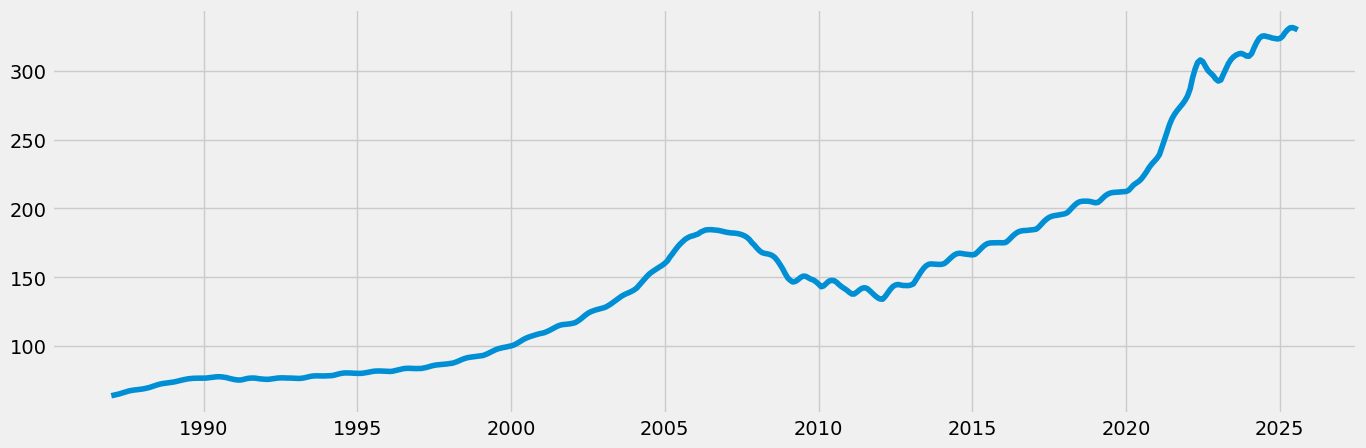

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

##### --------------------------------------------------

### [3] Make a subset of your data set if necessary. Think about the historical domain of the series to decide if you need to (if there are irrelevant historical events in your data that would bias your analysis, for example). Also, make sure your set doesn’t include any forecasted data.

#### - In a markdown cell below the subset (if you make one), explain what logic you were following when selecting your data points.

#### - Remember that if you subset your data, you’ll need to reset the index, subset, then reset the “Date” column as your index in the new dataframe.

In [10]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.tail()

,index,Value
603,2025-04-01,329.917
604,2025-05-01,331.458
605,2025-06-01,331.685
606,2025-07-01,331.003
607,2025-08-01,330.022


In [12]:
data_sub = data_2.loc[(data_2['index'] >= '1990-01-01') & (data_2['index'] < '2020-02-02')]

#### I wanted to chose the last 30 years because i think they are more relevant to the modern house market conditions, and aswell i have not included the last 4 years because there is forecast.

In [13]:
data_sub.shape

(362, 2)

In [14]:
data_sub.head()

,index,Value
180,1990-01-01,76.527
181,1990-02-01,76.587
182,1990-03-01,76.790
183,1990-04-01,77.039
184,1990-05-01,77.297


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['index']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['index'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1990-01-01,76.527
1990-02-01,76.587
1990-03-01,76.790
1990-04-01,77.039
1990-05-01,77.297


In [16]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

#### No missing values

In [17]:
# Check for duplicates

dups = data_sub.duplicated()

In [18]:
dups.sum()

np.int64(1)

#### There is one duplicate, i will inspect it.

In [19]:
data_sub[data_sub.duplicated(keep=False)]

,Value
datetime,
1993-09-01,78.2
1994-01-01,78.2


#### This duplicates is simply the same exact interest rate in two different months, so i believe i can keep it as it is.

##### --------------------------------------------------

### [4] Create a line chart of your data.

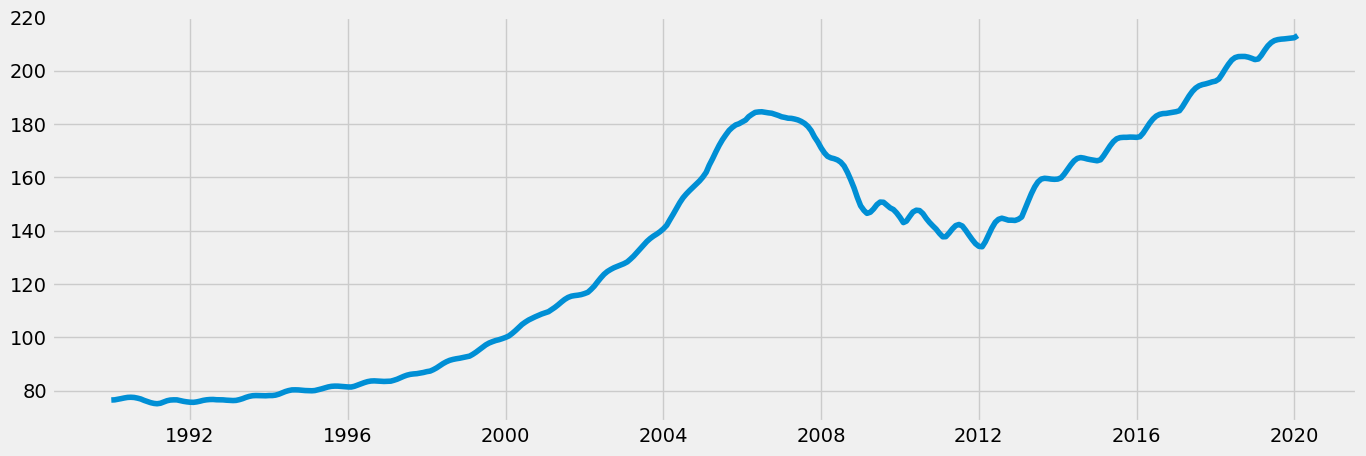

In [20]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

##### --------------------------------------------------

### [5] Decompose the data’s components. Analyze the results from the plot in a markdown cell.

In [21]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [22]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

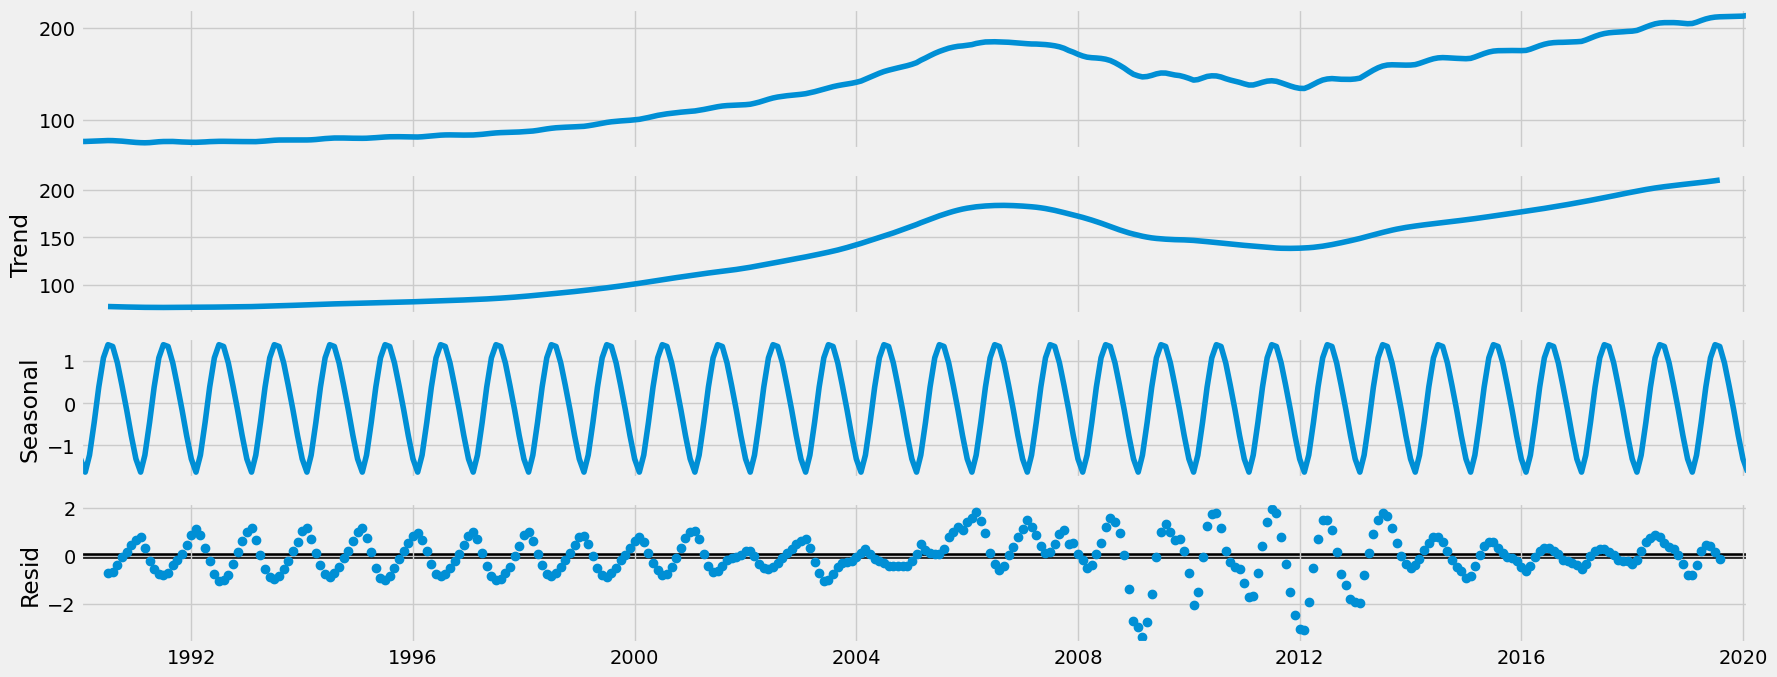

In [23]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The decomposition shows a clear upward trend and strong annual seasonality, confirming that the original series is non-stationary and requires differencing before stationarity tests or forecasting.

##### --------------------------------------------------

### [6] Conduct a Dickey-Fuller test to check for stationarity.

#### Interpret the results in a markdown cell and reference your null hypothesis.

In [24]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -0.671505
p-value                          0.853993
Number of Lags Used             13.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


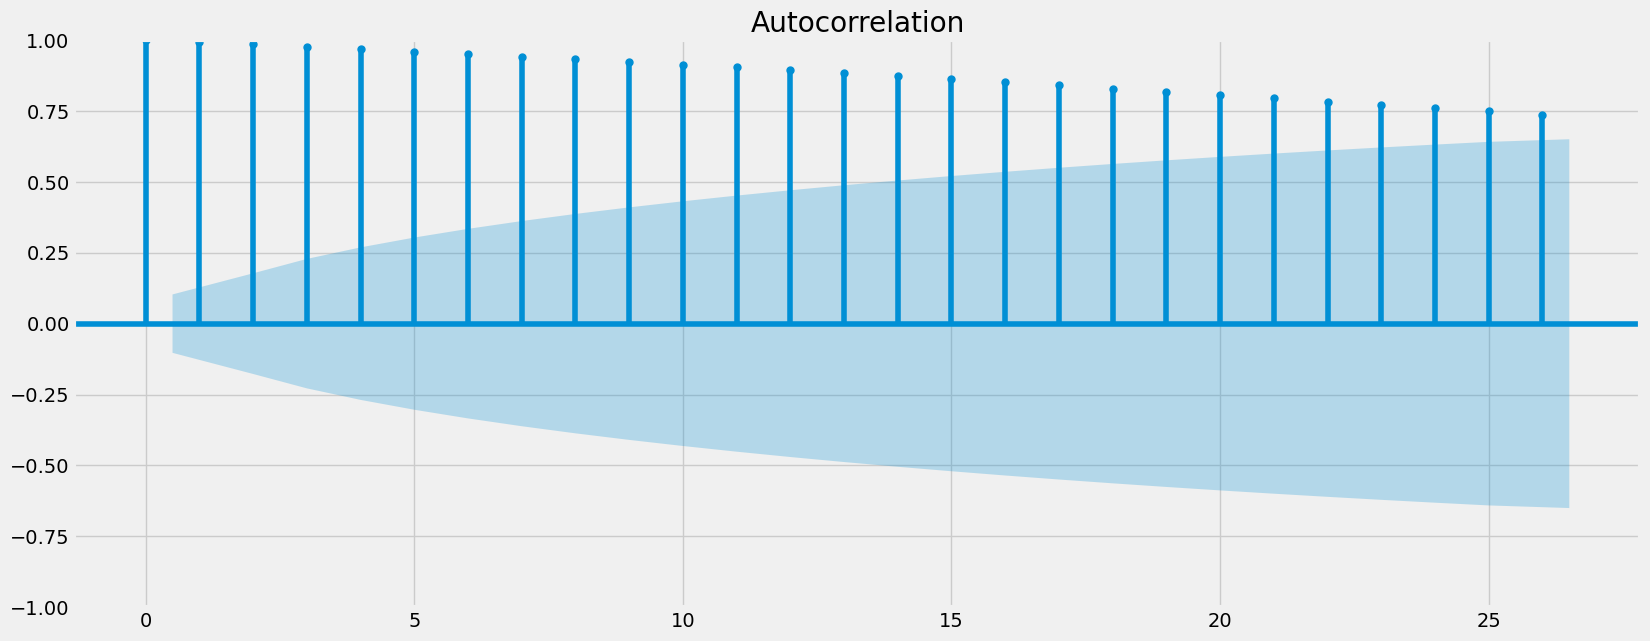

In [25]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(data_sub)
plt.show()

#### The series is non-stationary. The p-value is very high and the test statistic does not exceed the critical values, so we cannot reject the null hypothesis. Also, The ACF plot shows extremely slow decay in autocorrelation, with well over ten lags exceeding the confidence interval. This confirms the presence of trend and seasonality, and need to be differenced.

##### --------------------------------------------------

### [7] If your data isn’t stationary, conduct a round of differencing on it and repeat step 6.

In [26]:
data_diff = data_sub - data_sub.shift(1)

In [27]:
# Removing the missing values that came about as a result of the differencing.

data_diff.dropna(inplace = True)

In [28]:
data_diff.head(10)

,Value
datetime,
1990-02-01,0.060
1990-03-01,0.203
1990-04-01,0.249
1990-05-01,0.258
1990-06-01,0.208
1990-07-01,0.055
1990-08-01,-0.081
1990-09-01,-0.251
1990-10-01,-0.316


In [29]:
data_diff.columns

Index(['Value'], dtype='object')

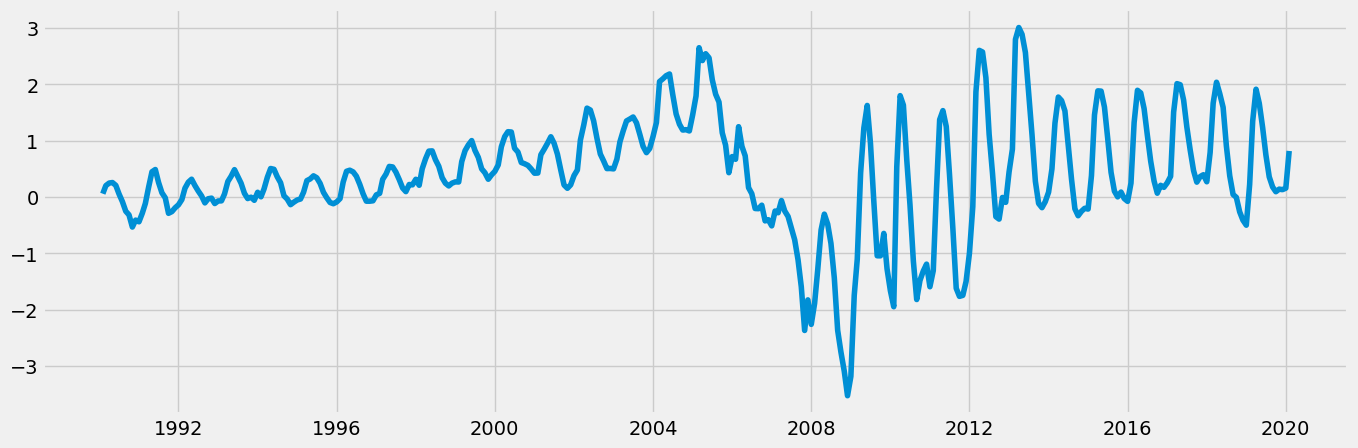

In [30]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [31]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.780771
p-value                          0.061073
Number of Lags Used             12.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


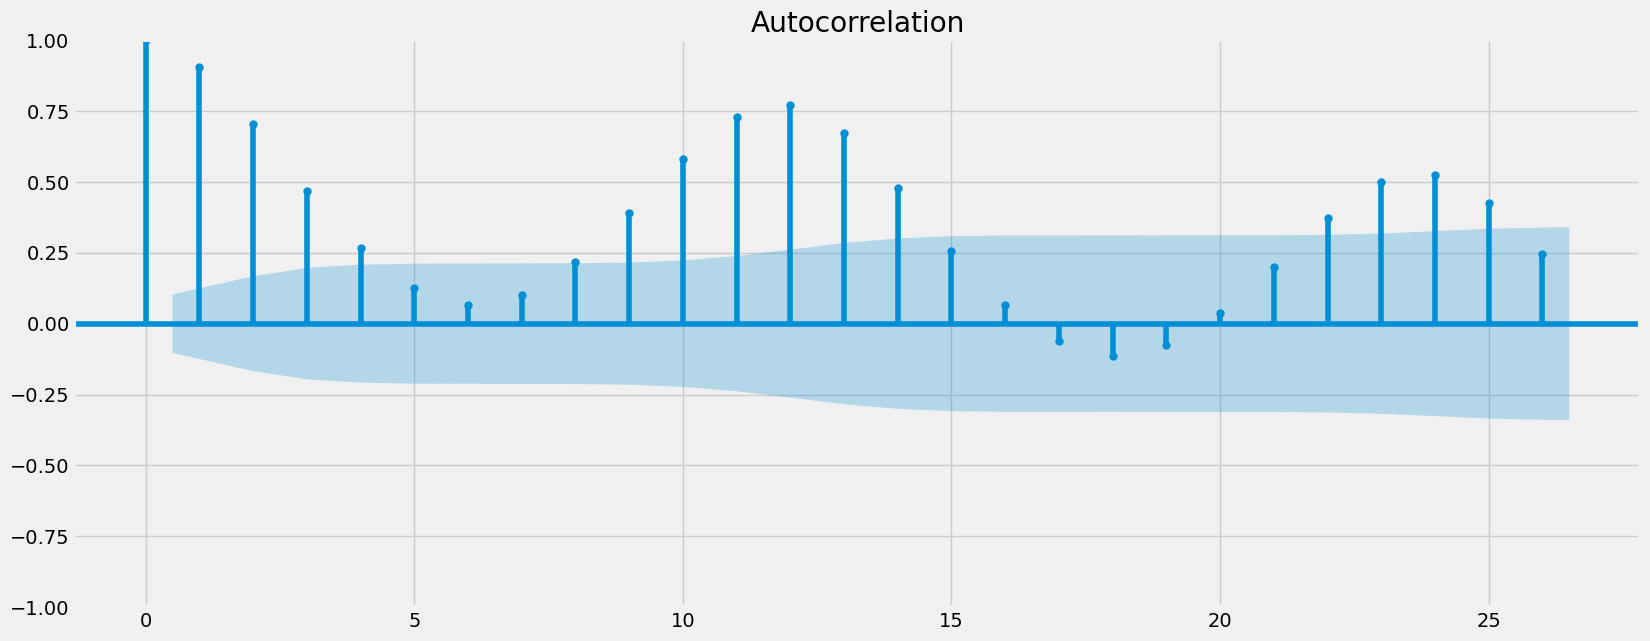

In [32]:
plot_acf(data_diff)
plt.show()

#### Test p-value is still slightly over 0.05 and the Autocorrelation chart shows again a big number of lags over the blue shaded area (12 lags over). Therefore i believe another round of differencing is required.

##### --------------------------------------------------

### [8] If your data still isn’t stationary, perform another round of differencing and repeat step 6.

In [33]:
data_diff_2 = data_diff - data_diff.shift(1)

In [34]:
# Removing the missing values that came about as a result of the differencing.

data_diff_2.dropna(inplace = True)

In [35]:
data_diff.head(10)

,Value
datetime,
1990-02-01,0.060
1990-03-01,0.203
1990-04-01,0.249
1990-05-01,0.258
1990-06-01,0.208
1990-07-01,0.055
1990-08-01,-0.081
1990-09-01,-0.251
1990-10-01,-0.316


In [36]:
data_diff_2.columns

Index(['Value'], dtype='object')

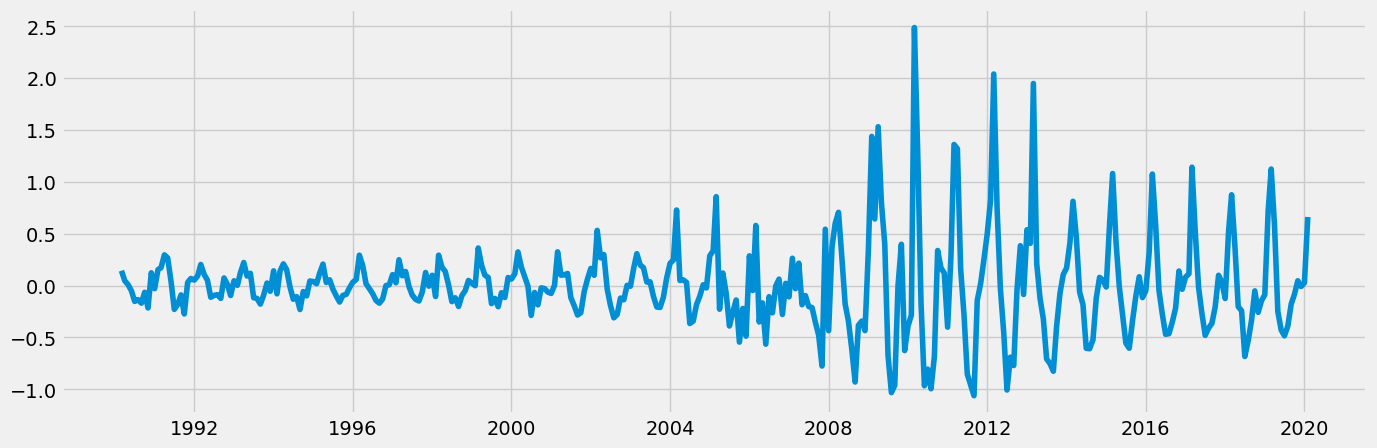

In [37]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [38]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                  -4.877917
p-value                          0.000038
Number of Lags Used             11.000000
Number of Observations Used    348.000000
Critical Value (1%)             -3.449282
Critical Value (5%)             -2.869881
Critical Value (10%)            -2.571214
dtype: float64


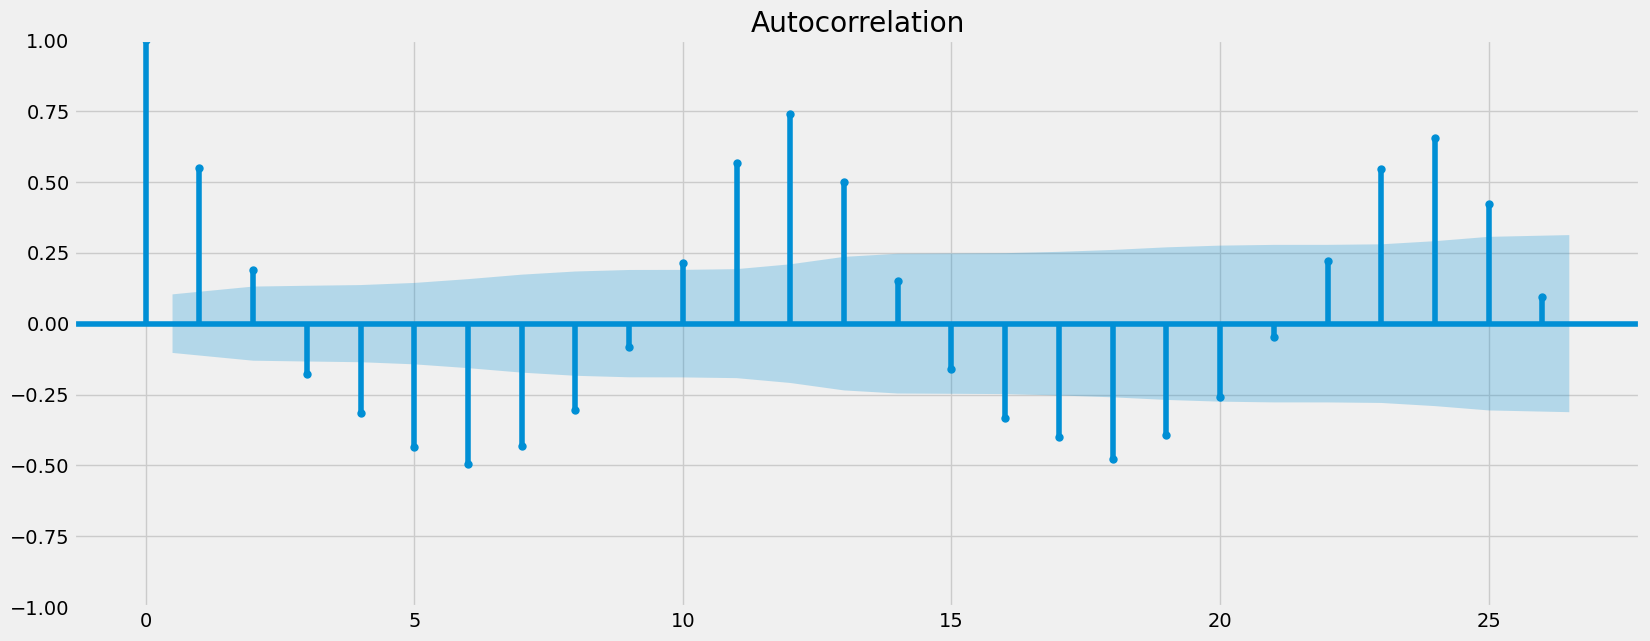

In [39]:
plot_acf(data_diff_2)
plt.show()

##### --------------------------------------------------

### [9] Check your data’s autocorrelations.

#### After applying a second round of differencing, the transformed series now fluctuates around zero with no visible long term trend. The Dickey Fuller test confirms stationarity, with a lower p-value (0.00004) and a higher test statistic (-4.88). The ACF plot shows only few strong autocorrelation on the lags, but we are still below 10 strong ones. Overall, the series can now be considered stationary, and no further differencing is necessary.